---
title: Triple Pendulum Example
type: submodule
---

In [1]:
%matplotlib inline

Try running with this variable set to true and to false and see the difference in the resulting equations of motion

In [2]:
use_constraints = False

Import all the necessary modules

In [3]:
# -*- coding: utf-8 -*-
"""
Written by Daniel M. Aukes
Email: danaukes<at>gmail.com
Please see LICENSE for full license.
"""

import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
plt.ion()
from math import pi

The next two lines create a new system object and set that system as the global system within the module so that other variables can use and find it.

In [4]:
system = System()
pynamics.set_system(__name__,system)

## Parameterization

### Constants

Declare constants and seed them with their default value.  This can be changed at integration time but is often a nice shortcut when you don't want the value to change but you want it to be represented symbolically in calculations

In [5]:
lA = Constant(1,'lA',system)
lB = Constant(1,'lB',system)
lC = Constant(1,'lC',system)

mA = Constant(1,'mA',system)
mB = Constant(1,'mB',system)
mC = Constant(1,'mC',system)

g = Constant(9.81,'g',system)
b = Constant(1e1,'b',system)
k = Constant(1e1,'k',system)

preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)

Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)

torque = Constant(0,'torque',system)
freq = Constant(3e0,'freq',system)

### Differentiable State Variables

Define your differentiable state variables that you will use to model the state of the system.  In this case $qA$, $qB$, and $qC$ are the rotation angles of a three-link mechanism

In [6]:
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)

### Initial Values
Define a set of initial values for the position and velocity of each of your state variables.  It is necessary to define a known.  This code create a dictionary of initial values.

In [7]:
initialvalues = {}
initialvalues[qA]=0*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=0*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=0*pi/180
initialvalues[qC_d]=0*pi/180

These two lines of code order the initial values in a list in such a way that the integrator can use it in the same order that it expects the variables to be supplied

In [8]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

## Kinematics

### Frames
Define the reference frames of the system

In [9]:
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)

### Newtonian Frame

It is important to define the Newtonian reference frame as a reference frame that is not accelerating, otherwise the dynamic equations will not be correct

In [10]:
system.set_newtonian(N)

Rotate each successive frame by amount q<new> from the last.  This approach can produce more complex equations but is representationally simple (Minimal Representation)

In [11]:
A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
B.rotate_fixed_axis_directed(A,[0,0,1],qB,system)
C.rotate_fixed_axis_directed(B,[0,0,1],qC,system)

### Vectors
Define the vectors that describe the kinematics of a series of connected lengths

* pNA - This is a vector with position at the origin.
* pAB - This vector is length $l_A$ away from the origin along the A.x unit vector
* pBC - This vector is length $l_B$ away from the pAB along the B.x unit vector 
* pCtip - This vector is length $l_C$ away from the pBC along the C.x unit vector 

Define my rigid body kinematics

![](/figures/kinematics/fourbar2.png)
![](../../../../static/figures/kinematics/fourbar2.png)

In [12]:
pNA=0*N.x
pAB=pNA+lA*A.x
pBC = pAB + lB*B.x
pCtip = pBC + lC*C.x

## Centers of Mass

It is important to define the centers of mass of each link.  In this case, the center of mass of link A, B, and C is halfway along the length of each

In [13]:
pAcm=pNA+lA/2*A.x
pBcm=pAB+lB/2*B.x
pCcm=pBC+lC/2*C.x

## Calculating Velocity

The angular velocity between frames, and the time derivatives of vectors are extremely useful in calculating the equations of motion and for determining many of the forces that need to be applied to your system (damping, drag, etc).  Thus, it is useful, once kinematics have been defined, to take or find the derivatives of some of those vectors for calculating  linear or angular velocity vectors

### Angular Velocity
The following three lines of code computes and returns the angular velocity between frames N and A (${}^N\omega^A$), A and B (${}^A\omega^B$), and B and C (${}^B\omega^C$).  In other cases, if the derivative expression is complex or long,  you can supply pynamics with a given angular velocity between frames to speed up computation time.

In [14]:
wNA = N.getw_(A)
wAB = A.getw_(B)
wBC = B.getw_(C)

### Vector derivatives
The time derivatives of vectors may also be 

vCtip = pCtip.time_derivative(N,system)

### Define Inertias and Bodies
The next several lines compute the inertia dyadics of each body and define a rigid body on each frame.  In the case of frame C, we represent the mass as a particle located at point pCcm.  

In [15]:
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)
#BodyC = Particle(pCcm,mC,'ParticleC',system)

## Forces and Torques
Forces and torques are added to the system with the generic ```addforce``` method.  The first parameter supplied is a vector describing the force applied at a point or the torque applied along a given rotational axis.  The second parameter is the  vector describing the linear speed (for an applied force) or the angular velocity(for an applied torque)

In [16]:
system.addforce(torque*sympy.sin(freq*2*sympy.pi*system.t)*A.z,wNA)

### Damper

In [17]:
system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)

### Spring Forces

Spring forces are a special case because the energy stored in springs is conservative and should be considered when calculating the system's potential energy.  To do this, use the ```add_spring_force``` command.  In this method, the first value is the linear spring constant.  The second value is the "stretch" vector, indicating the amount of deflection from the neutral point of the spring.  The final parameter is, as above, the linear or angluar velocity vector (depending on whether your spring is a linear or torsional spring)

In this case, the torques applied to each joint are dependent upon whether qA, qB, and qC are absolute or relative rotations, as defined above.

In [18]:
system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
system.add_spring_force1(k,(qB-preload2)*A.z,wAB)
system.add_spring_force1(k,(qC-preload3)*B.z,wBC)

(<pynamics.force.Force at 0x290477aef10>,
 <pynamics.spring.Spring at 0x290477ae400>)

### Gravity
Again, like springs, the force of gravity is conservative and should be applied to all bodies.  To globally apply the force of gravity to all particles and bodies, you can use the special ```addforcegravity``` method, by supplying the acceleration due to gravity as a vector.  This will get applied to all bodies defined in your system.

In [19]:
system.addforcegravity(-g*N.y)

## Constraints
Constraints may be defined that prevent the motion of certain elements.  Try turning on the constraints flag at the top of the script to see what happens.

In [20]:
if use_constraints:
    eq = []
    eq.append(pCtip)
    eq_d=[item.time_derivative() for item in eq]
    eq_dd=[item.time_derivative() for item in eq_d]
    eq_dd_scalar = []
    eq_dd_scalar.append(eq_dd[0].dot(N.y))
    constraint = AccelerationConstraint(eq_dd_scalar)
    system.add_constraint(constraint)

## F=ma
This is where the symbolic expressions for F and ma are calculated.  This must be done after all parts of the system have been defined.  The ```getdynamics``` function uses Kane's method to derive the equations of motion.

In [21]:
f,ma = system.getdynamics()

2021-07-22 13:50:52,813 - pynamics.system - INFO - getting dynamic equations


In [22]:
f

⎡          g⋅lA⋅mA⋅cos(qA)                                       g⋅lB⋅mB⋅sin(q
⎢-b⋅qA_d - ─────────────── - g⋅lA⋅mB⋅cos(qA) - g⋅lA⋅mC⋅cos(qA) + ─────────────
⎣                 2                                                         2 

A)⋅sin(qB)   g⋅lB⋅mB⋅cos(qA)⋅cos(qB)                                          
────────── - ─────────────────────── + g⋅lB⋅mC⋅sin(qA)⋅sin(qB) - g⋅lB⋅mC⋅cos(q
                        2                                                     

             g⋅lC⋅mC⋅(-sin(qB)⋅sin(qC) + cos(qB)⋅cos(qC))⋅cos(qA)   g⋅lC⋅mC⋅(-
A)⋅cos(qB) - ──────────────────────────────────────────────────── - ──────────
                                      2                                       

sin(qB)⋅cos(qC) - sin(qC)⋅cos(qB))⋅sin(qA)                                    
────────────────────────────────────────── - k⋅(-preload₁ + qA) + torque⋅sin(2
               2                                                              

                      g⋅lB⋅mB⋅sin(qA)⋅sin(qB)   

In [23]:
ma

⎡                                                                             
⎢                                                                        2    
⎢                                                                      lA ⋅mA⋅
⎢Izz_A⋅qA_dd + Izz_B⋅(qA_dd + qB_dd) + Izz_C⋅(qA_dd + qB_dd + qC_dd) + ───────
⎣                                                                           4 

                                                                              
                                                   2                          
qA_dd     2              2            lA⋅lB⋅mB⋅qA_d ⋅sin(qB)   lA⋅lB⋅mB⋅qA_dd⋅
───── + lA ⋅mB⋅qA_dd + lA ⋅mC⋅qA_dd + ────────────────────── + ───────────────
                                                2                        2    

                                                                              
                                2                                             
cos(qB)   lA⋅lB⋅mB⋅(qA_d + qB_d) ⋅sin(qB)         

## Solve for Acceleration

The next line of code solves the system of equations F=ma plus any constraint equations that have been added above.  It returns one or two variables.  func1 is the function that computes the velocity and acceleration given a certain state, and lambda1(optional) supplies the function that computes the constraint forces as a function of the resulting states

There are a few ways of solveing for a.  The below function inverts the mass matrix numerically every time step.  This can be slower because the matrix solution has to be solved for, but is sometimes more tractable than solving the highly nonlinear symbolic expressions that can be generated from the previous step.  The other options would be to use ```state_space_pre_invert```, which pre-inverts the equations symbolically before generating a numerical function, or ```state_space_post_invert2```, which adds Baumgarte's method for intermittent constraints.

In [24]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

2021-07-22 13:50:53,430 - pynamics.system - INFO - solving a = f/m and creating function
2021-07-22 13:50:53,599 - pynamics.system - INFO - substituting constrained in Ma-f.
2021-07-22 13:50:53,762 - pynamics.system - INFO - done solving a = f/m and creating function
2021-07-22 13:50:53,762 - pynamics.system - INFO - calculating function for lambdas


## Integration Tolerance
Specify the precision of the integration

In [25]:
tol = 1e-5

### Time 
Define variables for time that can be used throughout the script.  These get used to create the t array, a list of every time value that is solved for during integration

In [26]:
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

## Integrate

The next line of code integrates the function calculated

In [27]:
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2021-07-22 13:50:53,947 - pynamics.integration - INFO - beginning integration
2021-07-22 13:50:53,947 - pynamics.system - INFO - integration at time 0000.00
2021-07-22 13:50:54,163 - pynamics.integration - INFO - finished integration


## Outputs


The next section simply calculates and plots a variety of data from the previous simulation
### States

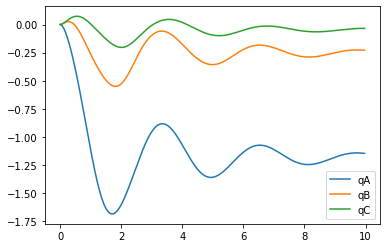

In [28]:
plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qA','qB','qC'])

### Energy

2021-07-22 13:50:54,465 - pynamics.output - INFO - calculating outputs
2021-07-22 13:50:54,485 - pynamics.output - INFO - done calculating outputs


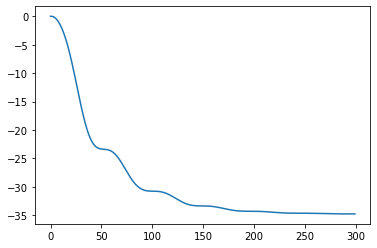

In [29]:
KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

### Constraint Forces

This line of code computes the constraint forces once the system's states have been solved for.

In [30]:
if use_constraints:
    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
    plt.figure()
    plt.plot(t, lambda2)

### Motion

2021-07-22 13:50:54,701 - pynamics.output - INFO - calculating outputs
2021-07-22 13:50:54,717 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

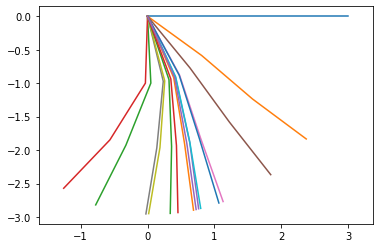

In [31]:
points = [pNA,pAB,pBC,pCtip]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

#### Motion Animation
in normal Python the next lines of code produce an animation using matplotlib

To plot the animation in jupyter you need a couple extra lines of code...